This notebook is a tutorial demonstrating the basics of `emf.subcalc`. We'll build a small model using Python only (without a template), compute results, and create some plots.

In [1]:
import emf.subcalc as sc
%matplotlib inline

Fundamentally, using `emf.subcalc` requires creating `Tower` and/or `Conductor` objects, putting them into a `Model` object, and running the `Model` object's `calculate` method to generate a `Results` object.

First step: creating `Tower`/`Conductor` objects

In this example we'll only use `Tower` objects because `Conductor` objects are usually not necessary. A `Conductor` object represents a single current carrying wire in a model domain, with the coordinates of the wire's path specified explicitly. A `Tower` object, on the other hand, represents a single tower/pole/frame with power lines strung up on it, with the positions of the wires specified in the tower's frame of reference instead of in explicit x,y,z coordinates. To create a `Tower`, we have to the following information:
* Group string. The "group" string is used to define which towers have power lines running between them.
* Sequence integer. The "seq" number defines the order in which power lines are strung between towers in the same group. 
* x and y coordinates in our model domain
* Rotation angle. The rotation angle is zero along the +x axis and increases toward the +y axis. This is different from the old SUBCALC program, which defines 0 rotation along the -y axis.
* Horizontal coordinates of wires on the tower, in the tower's reference frame. These are simply the horizontal distances of each wire from the tower.
* Vertical coordinates of wires on the tower, which are identical to z coordinates in the model domain. They're simply the distance above ground (where the ground surface is at z=0).
* The current amplitude of each wire
* The phase angle of each wire

Tower objects, and `emf.subcalc` in general, expect units of feet, Amps, and degrees.

The first group of Towers will have three power lines (one circuit). We'll make it run in the +y direction a little, then make a right angle and run in the +x direction:

In [2]:
#easier to keep Towers in a list instead of individual variables
tower_group_1 = [
    #         group   seq   x    y   rot   horz       vert        currents       phases
    sc.Tower('Line 1', 0,   0,   0,   0, [-5,0,5], [25,25,25], [100,100,100], [0,120,240]),
    sc.Tower('Line 1', 1,   0, 100, -45, [-5,0,5], [25,25,25], [100,100,100], [0,120,240]),
    sc.Tower('Line 1', 2, 100, 100, -90, [-5,0,5], [25,25,25], [100,100,100], [0,120,240])
]

The second group of Towers will also have three lines, but will only run in the +x direction.

In [3]:
tower_group_2 = [
    #         group   seq   x  y   rot   horz       vert        currents       phases
    sc.Tower('Line 2', 0,  10, 0, -90, [-5,0,5], [25,25,25], [100,100,100], [0,120,240]),
    sc.Tower('Line 2', 1, 100, 0, -90, [-5,0,5], [25,25,25], [100,100,100], [0,120,240])
]

Now that all of the `Tower` objects are created, we put them into a `Model` object, which is then used to set the model domain, set the sampling resolution, and get the results.

In [4]:
#Model objects can be initialized with no inputs, but here we pass a list containing all of our Towers.
#Behind the scenes, the Model object will run its add_tower() method on each of the Towers.
#We also pass a name string to give the Model a sense of identity. Otherwise it would feel insignificant.
towers = tower_group_1 + tower_group_2 #concatenate the lists
mod = sc.Model(name='tutorial', towers=towers)
#printing Model objects presents a short summary of the object's wires and sample grid
print(mod)

Model object
    name: 'tutorial'
    x limits: -16 to 111 ft
    y limits: -16 to 116 ft
    sample height (z): 3.28 ft
    total samples: 100453
    sample spacing: 0.409439 ft
    number of Tower objects: 5
    number of Tower groups: 2
    tower group names: 'Line 1', 'Line 2'
    number of Condutor objects: 0
    total number of wire segments: 9


The `Model` object has incorporated all of our `Tower` objects.

`Model` objects will automatically choose the extent of their sampling domains and their sampling resolution unless those properties are set directly. The model extent is determined by where power lines run through the model. To get the sampling extent, the `Model` finds the minimum and maximum coordinates of all the power lines in both directions (x and y), then applies some padding. The amount of padding can be adjusted using the `auto_lim_frac` property. The sampling resolution is automatically calculated so that the sample grid contains about 100,000 samples. The resolution can be adjusted using the `spacing` property or the total number of samples can be approximately set using the `N` property.

The `Model` lists the automatically chosen paremeters above, but we can set our own.

In [5]:
#set the model limits directly
mod.xlim = -20, 120
mod.ylim = -20, 120
#set the spacing/resolution
mod.spacing = 0.5

print(mod)

Model object
    name: 'tutorial'
    x limits: -20 to 120 ft
    y limits: -20 to 120 ft
    sample height (z): 3.28 ft
    total samples: 78961
    sample spacing: 0.5 ft
    number of Tower objects: 5
    number of Tower groups: 2
    tower group names: 'Line 1', 'Line 2'
    number of Condutor objects: 0
    total number of wire segments: 9


It looks like everything is in place. Now we can run the `Model` object's `calculate()` method to generate a `Results` object containing all of the computed fields.

In [6]:
#The calculate method parses all of the Tower data into individual wire segments,
# passes each wire segment to the magnetic field functions, then sums up the results
# of each segment.
res = mod.calculate()

all calculations complete. total calculation time: 0.579 seconds.


The calculations go very quickly for a small model with only 9 wire segments. Now we have a `Results` object stored in the `res` variable. We can print the `Results` object to get a quick summary of its contents.

In [7]:
print(res)

Results object
    name: 'tutorial'
    components/Bkeys: 'Bmax', 'Bres', 'By', 'Bz', 'Bx'
    active component/Bkey: 'Bmax'
    Bmax range: 0.425385 to 10.3558 mG
    x limits: -20 to 120 ft
    y limits: -20 to 120 ft
    total samples: 78961
    sample spacing: 0.5 ft
    number of Footprints: 2
    Footprint groups: 'Line 1', 'Line 2'


There are a few things to note.

First, the `Results` object lists five separate strings in its 'Bkeys' field. These refer to the components of the magnetic field stored in the object. We can access any of these components by changing the 'Bkey' property of the object to one of the 'Bkeys' that is listed. For example:

In [8]:
#first we check what the current 'Bkey' is
print(res.Bkey)

Bmax


In [9]:
#alright, the Results object is set to access the Bmax component
#the results are stored in 2D numpy arrays, accessible with the 'B' property of the object
#lets check out the fields
print(res.B)

[[ 2.68986205  2.73567943  2.78221949 ...,  1.06536488  1.03717138
   1.01007188]
 [ 2.73524702  2.78250297  2.83052232 ...,  1.08753242  1.05880299
   1.03118139]
 [ 2.78135114  2.83008632  2.87962759 ...,  1.11023782  1.080949
   1.05278185]
 ..., 
 [ 1.54177447  1.58112699  1.621142   ...,  1.04514615  1.01515312
   0.98638041]
 [ 1.5080385   1.54600023  1.58457145 ...,  1.02471079  0.99519756
   0.96689086]
 [ 1.47490731  1.51150765  1.54866683 ...,  1.00483964  0.97578537
   0.94792354]]


In [10]:
#now, if we change the 'Bkey' to something else, we will get different numbers from the 'B' property
#if we want to work with the x component of the results, we set 'Bkey' to 'Bx'
res.Bkey = 'Bx'
print(res.B)

[[ 1.68238043  1.70852002  1.73438084 ...,  0.0770671   0.07516712
   0.07331521]
 [ 1.73208841  1.75954664  1.78673026 ...,  0.07805676  0.07611252
   0.07421818]
 [ 1.78308678  1.81192051  1.84048499 ...,  0.07904461  0.07705569
   0.07511853]
 ..., 
 [ 0.8500505   0.8522119   0.85357281 ...,  0.02400158  0.02359008
   0.02318582]
 [ 0.81733663  0.81905182  0.81999706 ...,  0.02384174  0.02343428
   0.02303396]
 [ 0.78587686  0.78718186  0.78774677 ...,  0.02368101  0.02327759
   0.02288121]]


The 'Bkey' property of a `Results` object determines which component of the fields your working with. 'Bmax' is the default.

When `res` was printed, it also listed two "footprint" objects. Let's check one of them out.

In [11]:
print(res.footprints[0])

Footprint object
    name: 'Line 1'
    group: 'Line 1'
    x (ft): 0, 0, 100
    y (ft): 0, 100, 100
    power line?: True
    of concern?: False
    draw as loop?: False


A `Footprint` object represents the outline or path of some object in the model domain. When we ran `mod.calculate()` the `Model` object automatically converted its tower groups into `Footprint` objects representing the paths of the power lines. These footprints will show up when we plot the results:

(<matplotlib.figure.Figure at 0x88d5830>,
 <matplotlib.contour.QuadContourSet at 0x8970f90>)

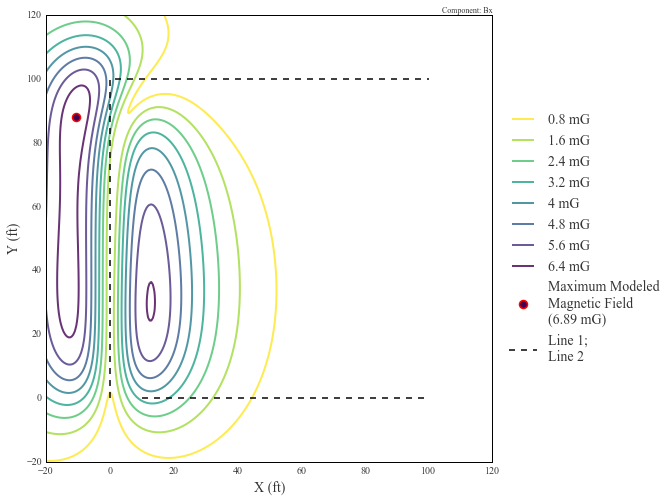

In [12]:
sc.ion()
sc.plot_contour(res)

Because the 'Bkey' property of the results is still set to 'Bx', the plotting functions work with the x component of the fields. To switch back to the maximum fields, we just have to switch 'Bkey' again and replot.

(<matplotlib.figure.Figure at 0xd316890>,
 <matplotlib.contour.QuadContourSet at 0xd463bb0>)

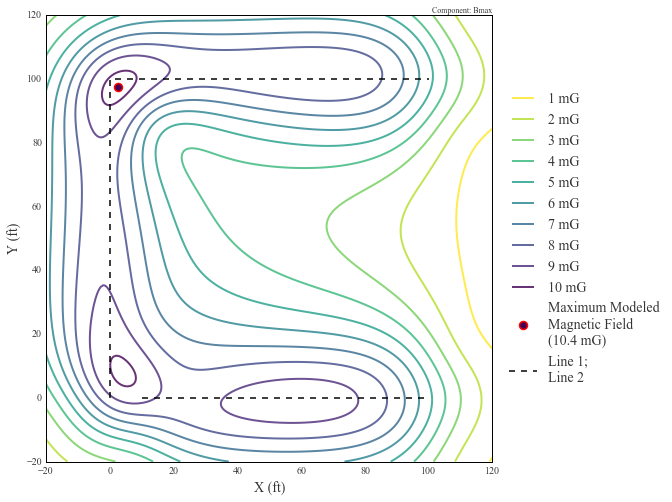

In [13]:
res.Bkey = 'Bmax'
sc.plot_contour(res)

(<matplotlib.figure.Figure at 0xd463b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0xd69e9d0>)

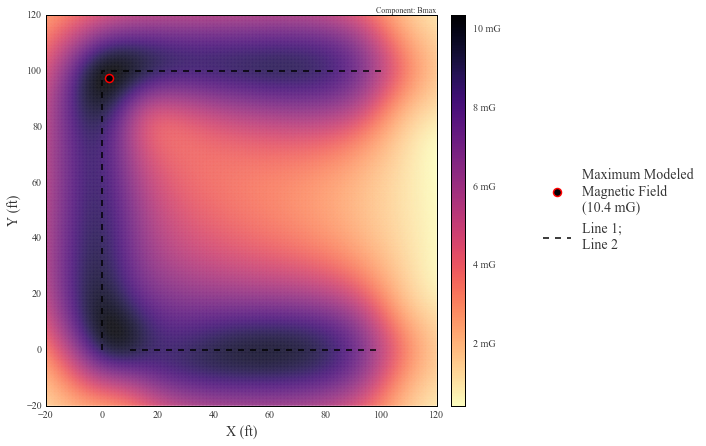

In [14]:
sc.plot_pcolormesh(res)

We've created a simple model, calculated results, and made some nice plots. These are some of the basics of `emf.subcalc`. Let's finish by exporting the results so that others could work with them outside of Python.

In [15]:
res.export()

results saved to: tutorial.xlsx
